In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/CTS_dataset.zip'  # Path to your zip file
extract_path = '/content/CTS_dataset/'               # Path where it will be extracted

# Create the folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")


Dataset extracted!


In [3]:
train_dir = '/content/CTS_dataset/Insurance-Fraud-Detection/Insurance-Fraud-Detection/train'
test_dir  = '/content/CTS_dataset/Insurance-Fraud-Detection/Insurance-Fraud-Detection/test'


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Test data generator only rescales
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)


Found 5200 images belonging to 2 classes.
Found 1416 images belonging to 2 classes.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)

# Flip the weights for correct imbalance handling
class_weights = {0: weights[1], 1: weights[0]}  # Minority class gets higher weight
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.52), 1: np.float64(13.0)}


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,377 (18.42 MB)

 Trainable params: 4,828,929 (18.42 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=15,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 75s 413ms/step - accuracy: 0.9208 - loss: 4.8608 - val_accuracy: 0.9354 - val_loss: 6.7493
Epoch 2/15
  1/162 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 1.0000 - loss: 9.3187e-25

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 1.0000 - loss: 9.3187e-25 - val_accuracy: 0.9347 - val_loss: 6.8867
Epoch 3/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 81s 493ms/step - accuracy: 0.9654 - loss: 2.4973 - val_accuracy: 0.9347 - val_loss: 8.8654
Epoch 4/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9688 - loss: 0.8869 - val_accuracy: 0.9339 - val_loss: 8.8678
Epoch 5/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 82s 507ms/step - accuracy: 0.9585 - loss: 2.2246 - val_accuracy: 0.9347 - val_loss: 5.0147
Epoch 6/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9375 - loss: 1.3359 - val_accuracy: 0.9339 - val_loss: 5.1566
Epoch 7/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 113s 373ms/step - accuracy: 0.9623 - loss: 1.2104 - val_accuracy: 0.9347 - val_loss: 4.3550
Epoch 8/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 1.0000 - loss: 0.0961 - val_accuracy: 0.9354 - val_loss: 4.3581
Epoch 9/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 83s 439ms/step - accuracy: 0.9642 - loss: 0.9380 - val_a

In [8]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy*100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9259 - loss: 0.9652
Test Accuracy: 93.43%


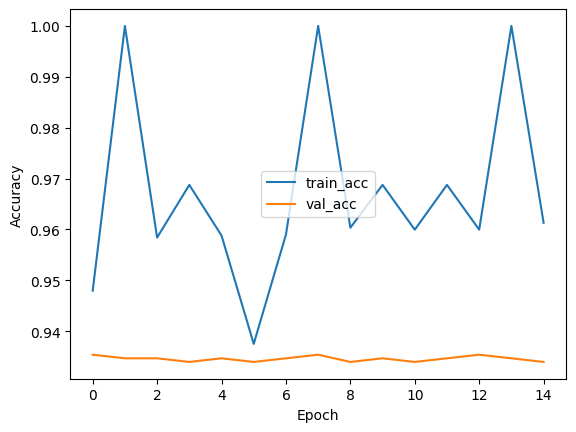

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Save the model in HDF5 format
model_save_path = '/content/car_fraud_model.h5'
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: /content/car_fraud_model.h5


In [11]:
from google.colab import files
files.download(model_save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


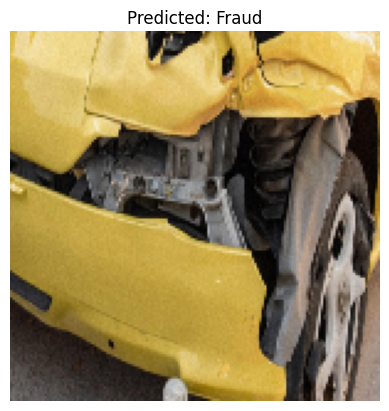

Prediction confidence: 1.00


In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# Pick a test image (replace 'Fraud' or 'Non-Fraud' as needed)
test_image_path = '/content/CTS_dataset/Insurance-Fraud-Detection/Insurance-Fraud-Detection/test/Fraud/4657.jpg'

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(150,150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 150, 150, 3)
img_array /= 255.0  # Rescale like training

# Make prediction
prediction = model.predict(img_array)
pred_label = 'Fraud' if prediction[0][0] > 0.5 else 'Non-Fraud'

# Show image and prediction
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {pred_label}')
plt.show()

print(f"Prediction confidence: {prediction[0][0]:.2f}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step
Total misclassified images: 93


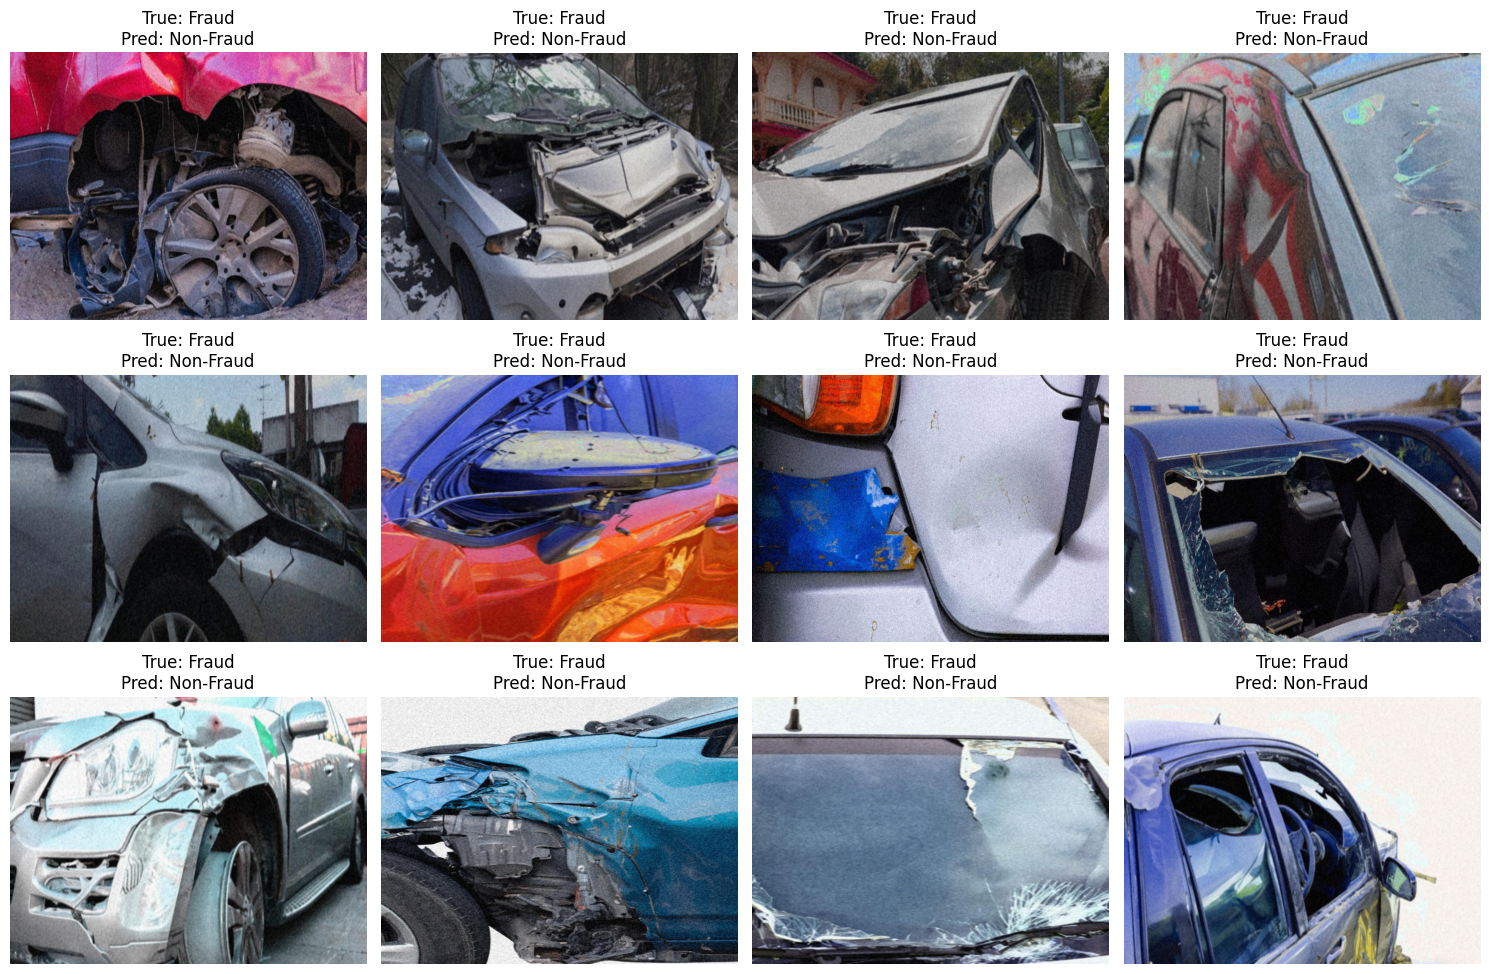

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Reset the generator so it starts from the beginning
test_generator.reset()

# Get predictions
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  # ['Fraud', 'Non-Fraud']

# Misclassified indices
misclassified_idx = np.where(pred_classes != true_classes)[0]
print(f"Total misclassified images: {len(misclassified_idx)}")

# Show some misclassified images
n_show = 12  # number of images to show
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_idx[:n_show]):
    # Load the image path
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[true_classes[idx]]}\nPred: {class_labels[pred_classes[idx]]}")

plt.tight_layout()
plt.show()


In [14]:
import os
import shutil
import numpy as np

# Reset the generator
test_generator.reset()

# Predictions
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Misclassified indices
misclassified_idx = np.where(pred_classes != true_classes)[0]
print(f"Total misclassified images: {len(misclassified_idx)}")

# Folder to save misclassified images
misclassified_dir = "/content/misclassified_images"
os.makedirs(misclassified_dir, exist_ok=True)

# Copy misclassified images into the folder
for idx in misclassified_idx:
    img_path = test_generator.filepaths[idx]
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[pred_classes[idx]]

    # Create subfolder for organization
    subfolder = os.path.join(misclassified_dir, f"True_{true_label}_Pred_{pred_label}")
    os.makedirs(subfolder, exist_ok=True)

    # Copy file
    shutil.copy(img_path, subfolder)

print(f"Misclassified images saved to: {misclassified_dir}")


45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step
Total misclassified images: 93
Misclassified images saved to: /content/misclassified_images


In [15]:
shutil.make_archive("/content/misclassified_images", 'zip', "/content/misclassified_images")

from google.colab import files
files.download("/content/misclassified_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>